Calculate Ocean Mixed Layer Budget using decomposition described in Zhang et. al. 2020 and Kang et. al. 2023


CMIP5 - TOS and TAS are both K
CMIP6 - TOS is C and TAS is K

# Utils

In [13]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from scipy.stats import linregress
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [2]:
ERA = "CMIP5"

# SANITY CHECK Plotting
def global_plot(data, lon, lat, cmap, pvalues=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1)):
    # plot map of global data with central longitude 180
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # East Pacific South America
    bound_region(ax1, lons=(-95, -70), lats=(-40, -5), color="black")
    # Southern Ocean
    bound_region(ax1, lons=(-180, -75), lats=(-70, -50), color="black")
    # East Pacific
    # bound_region(ax1, lons=(-135, -80), lats=(-5, 5), color="black")
    # West Pacific
    bound_region(ax1, lons=(110, 165), lats=(-5, 5), color="black")
    
    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax1.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )


    # Add Stippling
    if pvalues is not None:
        ax1.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(left_title, loc="left", fontweight="bold")
    ax1.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    
def create_scatter_hists(x6, y6, x5: list = [], y5: list = [], vline=0, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None: 
    # Set the default color cycle
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    # Create Pandas DataFrame from lists
    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    cmip6 = pd.DataFrame([x6, y6], index=["X", "Y"])
    cmip5 = pd.DataFrame([x5, y5], index=["X", "Y"])
    labels6 = pd.DataFrame([["CMIP6" for i in range(len(x6))]], index=["Ensemble"])
    labels5 = pd.DataFrame([["CMIP5" for i in range(len(x5))]], index=["Ensemble"])
    fbs = cmip6.T.append(cmip5.T, ignore_index=True)
    ens = labels6.T.append(labels5.T, ignore_index=True)
    df = pd.concat([fbs, ens], axis=1)

    # Create JointGrid object using Seaborn containing histogram and scatterplot
    g = sns.JointGrid(data=df, x="X", y="Y", hue="Ensemble")
    g.plot_marginals(sns.kdeplot, fill=True, alpha=.5, legend=False)
    g.plot_joint(sns.scatterplot, s=100, alpha=.5, edgecolor="black", legend=False)

    
    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))

    # Vertical Lines for Observations 
    if len(vline) >= 1:
        g.ax_joint.vlines(vline[0], ymin=ymin-bordery, ymax=ymax+bordery, color="navy", linestyle="--", label='Obs', alpha=.75) # ERA5
    if len(vline) >= 2:
        g.ax_joint.vlines(vline[1], ymin=ymin-bordery, ymax=ymax+bordery, color="navy", linestyle="--",  label='_nolegend_', alpha=.75) # NOAA
    if len(vline) >= 3:
        g.ax_joint.vlines(vline[2], ymin=ymin-bordery, ymax=ymax+bordery, color="navy", linestyle="--", label='_nolegend_', alpha=.75) # COBE

    # Vertical Lines for Ensemble Means
    g.ax_joint.vlines(np.mean(x5), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[1], linestyle="--", label='_nolegend_', alpha=.75, zorder=0) # COBE
    g.ax_joint.vlines(np.mean(x6), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], linestyle="--", label='_nolegend_', alpha=.75, zorder=0) # COBE
    
    # Add Letter title
    fig = plt.gcf()
    plt.text(0.05, .9, left_title, fontsize = 16, transform=fig.transFigure, fontweight="bold", zorder=.1)

    # Plot Regression Line for Combined Ensemble
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color="black", linestyle="--", label='_nolegend_')
    plt.text(.15, .75, f'r={r}', fontsize = 12, bbox = dict(edgecolor='white', facecolor = 'white', alpha = 0.5), transform=fig.transFigure, label='_nolegend_')

    # Add Regression Line for CMIP5 and CMIP6
    if len(x5) != 0: 
        slope, intercept, r5, p5, _ = linregress(x5,y5)
        r5, p5 = np.around(r5, 3), np.around(p5, 3)
        g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color=colors[1], linestyle="solid")


        slope, intercept, r6, p6, _ = linregress(x6,y6)
        r6, p6 = np.around(r6, 3), np.around(p6, 3)
        g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color=colors[0], linestyle="solid")

    # Clean up x and y limits and labels
    g.ax_joint.set_xlim(xmin-borderx, xmax+borderx)
    g.ax_joint.set_ylim(ymin-bordery, ymax+bordery)
    g.ax_joint.set_xlabel(xlabel)
    g.ax_joint.set_ylabel(ylabel)
    plt.legend(labels=[f"CMIP5 r={r5}", f"CMIP6 r={r6}", "Obs"], bbox_to_anchor=(1,0), loc="lower right",  bbox_transform=fig.transFigure)
    
def create_scatter(x6, y6, x5: list = [], y5: list = [], vline=0, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None:
    CMIP6_label = "CMIP6"
    if len(x5) != 0: 
        slope, intercept, r, p, _ = linregress(x5,y5)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP5_label = f"CMIP5 r={r},p={p}"
        plt.scatter(x5, y5, s=40, color="#b2df8a", edgecolor="black") # , label=x.model.value)
        plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
        plt.plot(np.array(x5), np.array(x5)*slope+intercept, color="#b2df8a", linestyle="--")

        slope, intercept, r, p, _ = linregress(x6,y6)
        r, p = np.around(r, 3), np.around(p, 3)
        plt.plot(np.array(x6), np.array(x6)*slope+intercept, color="#a6cee3", linestyle="--")
        CMIP6_label = f"CMIP6 r={r},p={p}"
    
    plt.scatter(x6, y6, s=40, edgecolor="black", color="#a6cee3") # , label=x.model.value)
    plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    if len(vline) >= 1:
        plt.vlines(vline[0], ymin=0, ymax=.6, color="red", linestyle="--", label="ERA5")
    if len(vline) >= 2:
        plt.vlines(vline[1], ymin=0, ymax=.6, color="blue", linestyle="--", label="NOAA")
    if len(vline) >= 3:
        plt.vlines(vline[2], ymin=0, ymax=.6, color="green", linestyle="--", label="COBE2")

    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    plt.plot(np.array(x), np.array(x)*slope+intercept, color="black", linestyle="--")
    plt.legend()
    
    plt.title(left_title, loc="left", fontweight="bold")
    plt.title(f"{right_title} r={r},p={p}", loc="right", fontweight="bold")


def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def drop_bad_models(ds1: xr.Dataset, era: str = "CMIP6") -> xr.Dataset:
    # Verify that both datasets have the same models

    if era == "CMIP6":
        sub = list(ds1.model.values)
        print(sub)
        sub.remove('CanESM5-1')
        sub.remove('CanESM5')
        sub.remove('NESM3')
        sub.remove('BCC-ESM1')
        sub.remove('CESM2-FV2')
        if 'CAMS-CSM1-0' in sub: sub.remove('CAMS-CSM1-0')

    if era == "CMIP5":
        sub = list(ds1.model.values)
        print(sub)
        sub.remove('BNU-ESM')
        sub.remove('CanESM2')
        sub.remove('FIO-ESM')
        sub.remove('CMCC-CESM')
        sub.remove('MPI-ESM-P')
        sub.remove('MRI-CGCM3')
        sub.remove('inmcm4')
        sub.remove('CMCC-CM')
        sub.remove("GFDL-ESM2M")
        sub.remove("GFDL-ESM2G")

    ds1 = ds1.sel(model=sub)

    return ds1


def get_regional_means(flux, name="NET"):
    # WE
    flux_west = flux.sel(lat=slice(-5, 5), lon=slice(110, 165)).spatial.average(name)[name]
    flux_east = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
    flux_WE = (flux_west - flux_east)
    # EPSA
    flux_EPSA = flux.sel(lat=slice(-40, -5), lon=slice(-95, -70)).spatial.average(name)[name]
    # SO
    flux_SO = flux.sel(lat=slice(-70, -50), lon=slice(-180, -75)).spatial.average(name)[name]
    # EP
    flux_EP = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
    # ETP
    flux_EPT = get_triangle(flux[name])
    flux_EPT = fix_coords(flux_EPT.rename(name).to_dataset()).spatial.average(name)[name]



    return {"WE": flux_WE, "EPSA": flux_EPSA, "SO": flux_SO, "EP": flux_EP, "EPT": flux_EPT}

def remove_land_full(ds, var="skt"):
    ds = ds.rename(var).to_dataset()
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.lon, ds.lat)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],ds[var].shape[1], 1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land

In [3]:
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "", ERA: str = "CMIP6") -> np.array:
    """Calculate the rolling gradient of a DataArray

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 12*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    if not save: 
        # load and return
        return xr.open_dataarray(f"data/piControl/rolling_gradient_{name}_{ERA}.nc")

    grads = np.full((data.model.size, int((len(data.time) - window) / step), data.lat.size, data.lon.size), np.nan)
    print(grads.shape)
    time_idx = xr.DataArray(np.arange(window, dtype="float"), dims="time")
    # time_idx = xr.DataArray(np.arange(12*30), dims=("time"))

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        # print(i, i+window)
        if j % 10 == 0: print(j)
        grads[:,j,:,:] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        

    # Convert to xarray
    da =  xr.DataArray(grads*window, dims=("model", "time", "lat", "lon"), coords={"model": data.model, "lat": data.lat, "lon": data.lon, "time": np.arange(grads.shape[1])})
    
    if save:
        da.to_netcdf(f"data/piControl/rolling_gradient_{name}_{ERA}.nc")
    
    return da

def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    # print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, _, nlon, ntime = ctos.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:,:nlats,i,:] = np.full((nmodel, nlats,ntime), np.nan) 
        
        jold = j
    
    return ctos

# Process the surface energy budget data

In [4]:
fluxes = [
        "rlds", # surface downwelling longwave flux, all sky
        "rldscs", # surface downwelling longwave flux, clear sky
        "rsds", # surface downwelling shortwave flux, all sky
        "rsdscs", # surface downwelling shortwave flux, clear sky
        "rlus", # surface upwelling longwave flux, all sky
        "rsus", # surface upwelling shortwave flux, all sky (probably don't need)
        "rsuscs", # surface upwelling shortwave flux, clear sky (probably don't need)
        "hfls", # surface upward latent heat flux
        "hfss", # surface upward shortwave heat flux
        "sfcWind", # surface wind speed
        "hur", # surface relative humidity
        "tos", # sea surface temperature
        "tas", # surface air temperature
]

In [5]:
def load_fluxes(ERA):
    ds = {}
    for flux in fluxes: 
        ds[flux] = xc.open_dataset(f"data/piControl/{flux}_mon_1850-2100_{ERA}_piControl.nc")[flux]

    ds_raw = xc.open_dataset(f"data/piControl/{flux}_mon_1850-2100_{ERA}_piControl.nc")

    if ERA == "CMIP6": # TAS is K but TOS is C 
        ds["tos"] = ds["tos"] + 273.15 # convert TOS from C to K
    elif ERA == "CMIP5": # TAS and TOS are K
        pass

    # Calculate Surface Energy Budget Terms
    LW = (ds["rlds"] - ds["rlus"]).rename("LW") # Net Downward Longwave Radiation
    LWC = (LW - ds["rldscs"]).rename("LWC") # Cloud Net Downward Longwave Radiation
    SW = (ds["rsds"] - ds["rsus"]).rename("SW") # Net Downward Shortwave Radiation
    SWC = (SW - (ds["rsdscs"] - ds["rsuscs"])).rename("SWC") # Cloud Net Downward Shortwave Radiation
    DT = (ds["tas"] - ds["tos"]).rename("DT") # Low Atmosphere Stability
    SH = ds["hfss"].rename("SH") # Net Upward Sensible Heat Flux
    LH = ds["hfls"].rename("LH") # Net Upward Latent Heat Flux
    TOS = ds["tos"].rename("TOS") # Sea Surface Temperature
    RH = ds["hur"].rename("RH") # Relative Humidity
    W = ds["sfcWind"].rename("W") # Wind Speed

    LH_Bar = LH.mean("time")
    RH_Bar = RH.mean("time")
    W_Bar = W.mean("time")
    DT_Bar = DT.mean("time")

    Lv = 2.5e6 # Latent Heat of Vaporization
    Rv = 461.5 # Gas Constant for Water Vapor
    alpha = Lv/(Rv*(TOS.mean("time"))**2)
    
    FLUXES = {
        "LW": LW, 
        "LWC": LWC, 
        "SW": SW,
        "SWC": SWC,
        "DT": DT,
        "SH": SH,
        "LH": LH,
        "TOS": TOS,
        "RH": RH,
        "W": W
    }
    AVGES = {
        "LH_Bar": LH_Bar,
        "RH_Bar": RH_Bar,
        "W_Bar": W_Bar,
        "DT_Bar": DT_Bar,
        "alpha": alpha,
    }
    
    return ds_raw, FLUXES, AVGES

# ds_raw, FLUXES_CMIP5 , AVGES_CMIP5 = load_fluxes("CMIP5")
# ds_raw, FLUXES_CMIP6, AVGES_CMIP6 = load_fluxes("CMIP6")

# Calculate Rolling Anomalies 

In [22]:
# eis_anoms_cmip5 = xc.open_dataset("data/piControl/EIS_anoms_mon_1850-2000_CMIP5_piControl.nc")
# eis_anoms_cmip6 = xc.open_dataset("data/piControl/EIS_anoms_mon_1850-2000_CMIP6_piControl.nc")

# eis_cmip6_trends = calculate_rolling_gradient(eis_anoms_cmip6["eis"], save=True, name="eis", ERA="CMIP6")
# eis_cmip5_trends = calculate_rolling_gradient(eis_anoms_cmip5["eis"], save=True, name="eis", ERA="CMIP5")

In [6]:
# Merge all terms into one dataset
print("Merging datasets...")
# ds_seb = [FLUXES_CMIP5["TOS"].sel(model=["MIROC-ESM"])]
keys = ["SW", "SWC", "TOS", "DT", "SH", "LH", "W", "RH"]
# Calculate Anomalies
print("Calculating Anomalies...")
ds_trends = {}
SAVE = True
for i, (key, var) in enumerate(FLUXES_CMIP5.items()): 
    if key not in keys: continue

    ds_var = xr.merge([var, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])
    for var_name in ds_var: 
        print(f"Calculating Anomalies for {var_name}...")
        ds_anoms = ds_var.temporal.departures(var_name, "month")
        ds_trends[var_name] = calculate_rolling_gradient(ds_anoms[var_name], save=SAVE, name=var_name)
        break

# Calculate tendency terms
CMIP6 Note to self: All of these forcing tendencies have been multiplied by 12*30 (i.e. they are 30 year trends) except for RH. To convert to 10 year trends, simply divide by 3


In CMIP5 all of these are 12*30 year trends.

In [6]:
def get_shared_models(vars):
    models = []
    for var in vars:
        models.append(var.model.values)
    shared_models = list(set.intersection(*map(set, models)))
    return shared_models

def _load_tendencies(ERA, AVGES):

    SH_T = drop_bad_models(xr.open_dataarray(f"data/piControl/rolling_gradient_SH_{ERA}.nc"), era=ERA)
    LH_T = xr.open_dataarray(f"data/piControl/rolling_gradient_LH_{ERA}.nc")
    LW_T = xr.open_dataarray(f"data/piControl/rolling_gradient_LW_{ERA}.nc")
    LWC_T = xr.open_dataarray(f"data/piControl/rolling_gradient_LWC_{ERA}.nc")
    SW_T = xr.open_dataarray(f"data/piControl/rolling_gradient_SW_{ERA}.nc")
    SWC_T = xr.open_dataarray(f"data/piControl/rolling_gradient_SWC_{ERA}.nc")
    W_T = xr.open_dataarray(f"data/piControl/rolling_gradient_W_{ERA}.nc")
    RH_T = xr.open_dataarray(f"data/piControl/rolling_gradient_RH_{ERA}.nc")
    DT_T = xr.open_dataarray(f"data/piControl/rolling_gradient_DT_{ERA}.nc")
    TOS_T = xr.open_dataarray(f"data/piControl/rolling_gradient_TOS_{ERA}.nc")
    EIS_T = xr.open_dataarray(f"data/piControl/rolling_gradient_eis_{ERA}.nc")

    shared_models = get_shared_models([SH_T, LH_T, LW_T, LWC_T, SW_T, SWC_T, W_T, RH_T, DT_T, TOS_T, EIS_T, AVGES["RH_Bar"], AVGES["LH_Bar"], AVGES["DT_Bar"], AVGES["W_Bar"], AVGES["alpha"]])

    SH_T = SH_T.sel(model=shared_models)
    LH_T = LH_T.sel(model=shared_models) 
    LW_T = LW_T.sel(model=shared_models) 
    LWC_T = LWC_T.sel(model=shared_models) 
    SW_T = SW_T.sel(model=shared_models) 
    SWC_T = SWC_T.sel(model=shared_models) 
    W_T = W_T.sel(model=shared_models) 
    RH_T = RH_T.sel(model=shared_models) 
    DT_T = DT_T.sel(model=shared_models) 
    EIS_T = EIS_T.sel(model=shared_models) 
    TOS_T = TOS_T.sel(model=shared_models)/3

    RH_Bar = AVGES["RH_Bar"].sel(model=shared_models) 
    LH_Bar = AVGES["LH_Bar"].sel(model=shared_models) 
    DT_Bar = AVGES["DT_Bar"].sel(model=shared_models) 
    W_Bar = AVGES["W_Bar"].sel(model=shared_models) 
    alpha = AVGES["alpha"].sel(model=shared_models) 

    print("Number of shared models: ", len(shared_models))
    
    return (SH_T, LH_T, SW_T, LW_T, SWC_T, LWC_T, RH_T, DT_T, W_T, TOS_T, EIS_T), (LH_Bar, W_Bar, DT_Bar, RH_Bar, alpha), shared_models


def calc_seb(ERA, AVGES):
    (SH_T, LH_T, SW_T, LW_T, SWC_T, LWC_T, RH_T, DT_T, W_T, TOS_T, EIS_T), (LH_Bar, W_Bar, DT_Bar, RH_Bar, alpha), shared_models = _load_tendencies(ERA, AVGES)
    # Convert from K/30yrs to K/decade by dividing by 3

    # Ocean Heat Transport
    O_T = LW_T + SW_T - SH_T - LH_T # Calculate ocean heat transport as residual
    # Ocean Heat Transport Tendency
    O_T = -O_T/(alpha*LH_Bar)/3
    # Sensible Heat Flux Tendency
    SH_T = SH_T/(alpha*LH_Bar)/3
    # Longwave Radiative Forcing
    LW_T = LW_T/(alpha*LH_Bar)/3
    # Shortwave Radiative Forcing
    SW_T = SW_T/(alpha*LH_Bar)/3
    # Latent Heat Flux Tendency
    LH_TW = W_T/(alpha*W_Bar)/3 # Wind Driven
    LH_TRH = (RH_T)/(alpha*(np.exp(alpha*DT_Bar) - RH_Bar))/3 # Relative Humidity Driven
    LH_TDT = RH_Bar*DT_T/(np.exp(alpha*DT_Bar) - RH_Bar)/3 # Temperature Driven
    LH_TDT = LH_TDT.transpose("model", "time", "lat", "lon")
    # Cloud Radiative Forcing
    LWC_T = LWC_T/(alpha*LH_Bar)/3
    SWC_T = SWC_T/(alpha*LH_Bar)/3
    CLOUD_T = LWC_T + SWC_T
    LW_Other = LW_T - LWC_T
    SW_Other = SW_T - SWC_T

    NET = O_T + LW_T + SW_T - SH_T - LH_TW - LH_TRH - LH_TDT 

    SEB = xr.merge([
        NET.rename("NET"),
        O_T.rename("O"),
        -LH_TW.rename("W"), 
        -LH_TRH.rename("RH"), 
        -LH_TDT.rename("DT"), 
        -(LH_TW + LH_TRH + LH_TDT).rename("LH_Other"),
        SH_T.rename("SH"), 
        SW_T.rename("SW"), 
        LW_T.rename("LW"),
        SWC_T.rename("SWC"), 
        LWC_T.rename("LWC"),
        TOS_T.rename("TOS"),
        CLOUD_T.rename("CLOUD"), 
        LW_Other.rename("LW_Other"),
        SW_Other.rename("SW_Other"),
        EIS_T.rename("EIS"),
    ])
    SEB = SEB.drop("plev")
    SEB = fix_coords(SEB)
    
    return SEB, shared_models

In [7]:
SEB_CMIP6, shared_models_cmip6 = calc_seb(ERA="CMIP6", AVGES=AVGES_CMIP6)
SEB_CMIP5, shared_models_cmip5 = calc_seb(ERA="CMIP5", AVGES=AVGES_CMIP5)

['E3SM-1-1', 'E3SM-1-0', 'KIOST-ESM', 'CIESM', 'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CESM2-FV2', 'CESM2', 'FGOALS-f3-L', 'CAS-ESM2-0', 'FGOALS-g3', 'SAM0-UNICON', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-2-H', 'GISS-E2-1-H', 'GISS-E2-2-G', 'GISS-E2-1-G', 'IITM-ESM', 'CanESM5', 'CAMS-CSM1-0', 'MCM-UA-1-0', 'KACE-1-0-G', 'INM-CM5-0', 'INM-CM4-8', 'MPI-ESM-1-2-HAM', 'TaiESM1', 'EC-Earth3-LR', 'EC-Earth3-Veg-LR', 'EC-Earth3', 'EC-Earth3-Veg', 'EC-Earth3-AerChem', 'CMCC-ESM2', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'MRI-ESM2-0', 'ACCESS-CM2', 'NESM3', 'MIROC6', 'IPSL-CM6A-LR', 'NorESM1-F', 'NorCPM1', 'FIO-ESM-2-0', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'AWI-CM-1-1-MR', 'EC-Earth3-CC', 'NorESM2-MM', 'E3SM-2-0', 'CanESM5-1', 'E3SM-2-0-NARRM']
Number of shared models:  35
['CNRM-CM5', 'bcc-csm1-1', 'bcc-csm1-1-m', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GFDL-CM3', 'FGOALS-g2', 'CESM1-WACCM', 'CESM1-CAM5', 'CESM1-FASTCHEM', 'CESM1-BGC', 'IPSL-CM5B-LR', 'IPSL-CM

In [9]:
SEB_CMIP5.to_netcdf("data/piControl/SEB_CMIP5_full.nc")
SEB_CMIP6.to_netcdf("data/piControl/SEB_CMIP6_full.nc")

In [7]:
SEB_CMIP6 = xr.open_dataset("data/piControl/SEB_CMIP6_full.nc")
SEB_CMIP5 = xr.open_dataset("data/piControl/SEB_CMIP5_full.nc")
shared_models_cmip6 = SEB_CMIP6.model.values
shared_models_cmip5 = SEB_CMIP5.model.values

## Sanity Checks

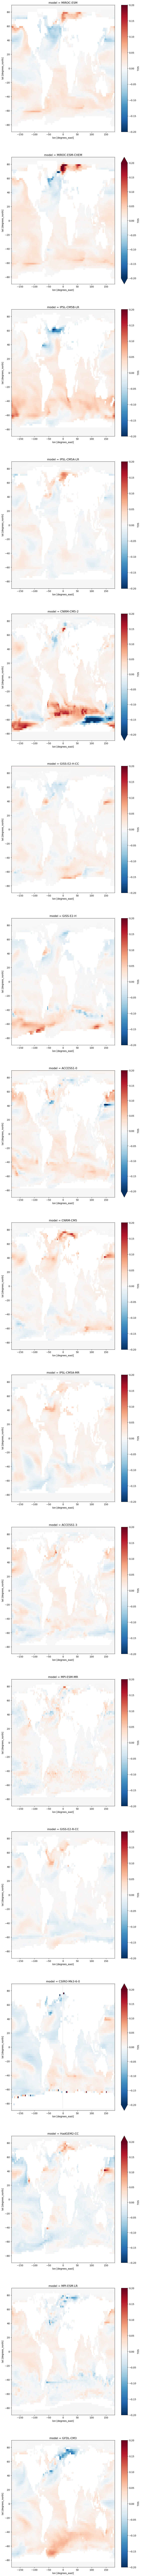

In [25]:
# Create number of ax as models
fig, axs = plt.subplots(len(shared_models_cmip5), 1, figsize=(10, 200))
axs = axs.flatten()
for i in range(0, len(shared_models_cmip5)):
    SEB_CMIP5["TOS"].isel(model=i).mean("time", skipna=False).plot(ax=axs[i], vmin=-.2, vmax=.2, cmap="RdBu_r")

In [65]:
from scipy.stats import linregress
a = ((fix_coords(ds_trends["TOS"].sel(model="MIROC-ESM").drop("model").rename("TOS").to_dataset())).spatial.average("TOS")["TOS"])#.plot()
linregress(a.time.values, a.values)

LinregressResult(slope=0.00043917689994894967, intercept=-0.016490529253012108, rvalue=0.15347655368129523, pvalue=0.09421225149569562, stderr=0.0002603036919590109, intercept_stderr=0.017921614606589396)

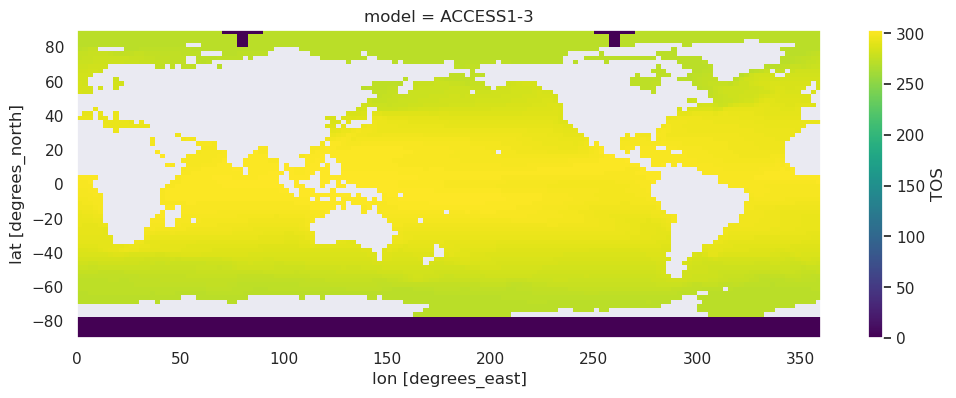

In [50]:
FLUXES_CMIP5["TOS"].sel(model="ACCESS1-3").mean("time").plot()

In [54]:
SEB_CMIP5.model

<xarray.DataArray 'model' (model: 17)>
array(['CNRM-CM5-2', 'ACCESS1-3', 'GISS-E2-H', 'IPSL-CM5A-MR', 'MIROC-ESM',
       'MPI-ESM-LR', 'ACCESS1-0', 'GFDL-CM3', 'CNRM-CM5', 'GISS-E2-R-CC',
       'MPI-ESM-MR', 'GISS-E2-H-CC', 'CSIRO-Mk3-6-0', 'IPSL-CM5B-LR',
       'IPSL-CM5A-LR', 'HadGEM2-CC', 'MIROC-ESM-CHEM'], dtype=object)
Coordinates:
  * model    (model) object 'CNRM-CM5-2' 'ACCESS1-3' ... 'MIROC-ESM-CHEM'

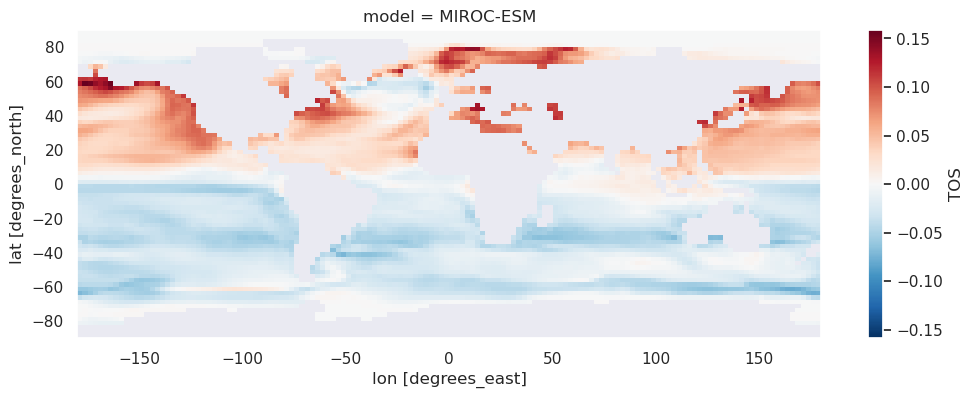

In [55]:
SEB_CMIP5.mean("time").isel(model=4)["TOS"].plot()

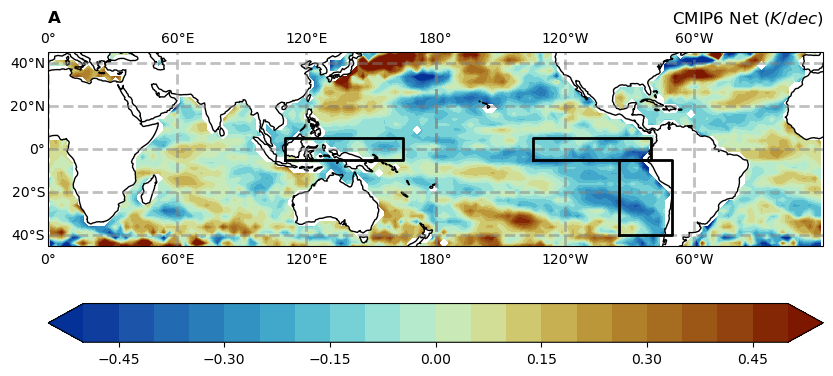

In [15]:
global_plot(
    data=SEB_CMIP6["NET"].sel(model="HadGEM3-GC31-MM").isel(time=1), 
    lat=SEB_CMIP6["NET"].lat,
    lon=SEB_CMIP6["NET"].lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="A", 
    right_title="CMIP6 Net $(K/dec)$"
)

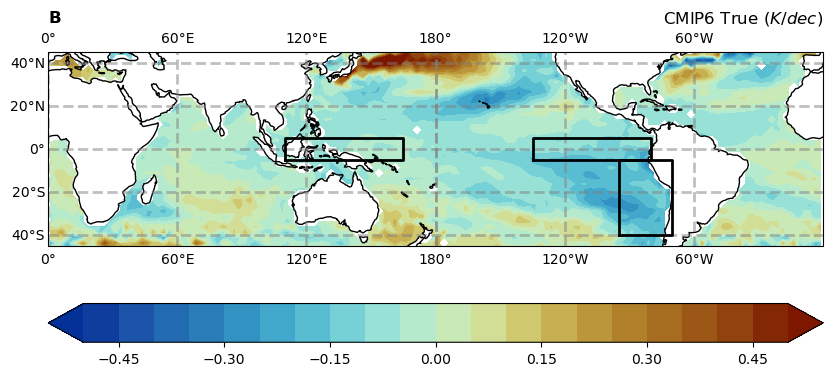

In [16]:
global_plot(
    data=SEB_CMIP6["TOS"].sel(model="HadGEM3-GC31-MM").isel(time=1), 
    lat=SEB_CMIP6["TOS"].lat,
    lon=SEB_CMIP6["TOS"].lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="B", 
    right_title="CMIP6 True $(K/dec)$"
)

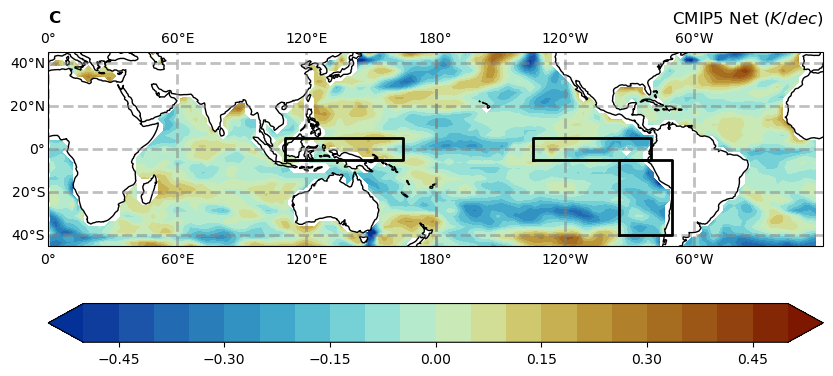

In [17]:
global_plot(
    data=SEB_CMIP5["NET"].sel(model="CNRM-CM5").isel(time=1), 
    lat=SEB_CMIP5["NET"].lat,
    lon=SEB_CMIP5["NET"].lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="C", 
    right_title="CMIP5 Net $(K/dec)$"
)

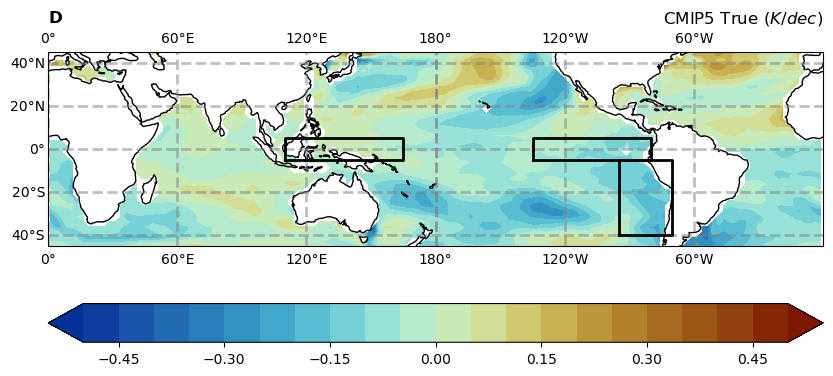

In [18]:
global_plot(
    data=SEB_CMIP5["TOS"].sel(model="CNRM-CM5").isel(time=1), 
    lat=SEB_CMIP5["TOS"].lat,
    lon=SEB_CMIP5["TOS"].lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="D", 
    right_title="CMIP5 True $(K/dec)$"
)

# Load SST Tendencies

In [8]:
# Load Rolling Gradient for Regions TOS
SST_T_EPSA_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificSA_trend.nc").sel(model=shared_models_cmip6)
SST_T_WE_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_WE-Trend.nc").sel(model=shared_models_cmip6)
SST_T_E_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacific_trend.nc").sel(model=shared_models_cmip6)
SST_T_SO_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_southernOcean_trend.nc").sel(model=shared_models_cmip6)
SST_T_EPT_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc").sel(model=shared_models_cmip6)

# Load Rolling Gradient for Regions TOS
SST_T_EPSA_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificSA_trend.nc").sel(model=shared_models_cmip5)
SST_T_WE_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_WE-Trend.nc").sel(model=shared_models_cmip5)
SST_T_E_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacific_trend.nc").sel(model=shared_models_cmip5)
SST_T_SO_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_southernOcean_trend.nc").sel(model=shared_models_cmip5)
SST_T_EPT_CMIP5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc").sel(model=shared_models_cmip5)

# SEB Composites

(0.0, 1.0)

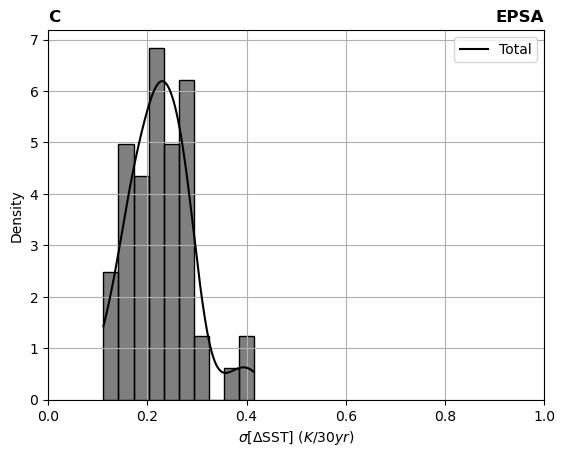

In [48]:
import seaborn as sns
import pandas as pd
# sns.histplot(SST_T_SO_CMIP6.std("time").to_pandas(), kde=True, stat='density', bins=10)
# sns.histplot(SST_T_SO_CMIP5.std("time").to_pandas(), kde=True, stat='density', bins=10)
plt.grid()
sns.histplot(pd.concat([SST_T_EPSA_CMIP6.std("time").to_pandas(), SST_T_EPSA_CMIP5.std("time").to_pandas()]), kde=True, stat='density', bins=10, color="black")
# plt.legend(["CMIP6", "CMIP5", "Total"])
plt.legend(["Total"])
plt.xlabel(r"$\sigma$[$\Delta$SST] $(K/30yr)$")
plt.title("EPSA", loc="right", fontweight="bold")
plt.title("C", loc="left", fontweight="bold")
plt.xlim(0, 1)

In [50]:
linregress(SST_T_EPSA_CMIP6.std("time"), SST_T_EPT_CMIP6.std("time"))

LinregressResult(slope=1.0757193578877278, intercept=0.02896306772083626, rvalue=0.908020444399827, pvalue=2.1136961869761257e-14, stderr=0.08511401232659704, intercept_stderr=0.020298789726113136)

In [24]:
def composite_sigma_anoms(X, Y, var_name, region="EPSA", remove_land=True):
    dsX, dsY, dsY_region_mean, dsY_region_var = [], [], [], []

    Y_ocean = remove_land_full(ds=Y[var_name], var=var_name)
    Y_region = get_regional_means(Y, name=var_name)[region]

    for model in X.model:
        cX = X.sel(model=model)
        cY = Y_ocean.sel(model=model)
        cY_region = Y_region.sel(model=model)

        idxMax = cX > (cX.mean("time") + cX.std("time"))

        # cX_max = cX[idxMax].mean("time")
        # cY_max = cY[idxMax, :, :].mean("time")
        # cY_region_mean = cY_region[idxMax].mean("time")
        # cY_region_var = cY_region[idxMax].std("time")

        cX_max = cX[:].mean("time")
        cY_max = cY[:, :, :].std("time")
        cY_region_mean = cY_region[:].mean("time")
        cY_region_var = cY_region[:].std("time")
        

        dsX.append(cX_max)
        dsY.append(cY_max)
        dsY_region_mean.append(cY_region_mean)
        dsY_region_var.append(cY_region_var)

    # convert to DataArray
    dsX = xr.concat(dsX, dim="model")
    dsY = xr.concat(dsY, dim="model")
    dsY_region_mean = xr.concat(dsY_region_mean, dim="model")
    dsY_region_var = xr.concat(dsY_region_var, dim="model")


    return dsX, dsY, dsY_region_mean, dsY_region_var

# Regional Bar Plots of SEB for 1 sig

In [29]:
# var_names = ["TOS", "NET", "SW", "LW", "LWC", "SWC", "CLOUD", "SH", "LH_Other", "O"]
# ticklabelsMean = [r"$\Delta T$", r"$\Delta T_{SUM}$", r"$\Delta T_{SW}$", r"$\Delta T_{LW}$", r"$\Delta T_{LWC}$", r"$\Delta T_{SWC}$", r"$\Delta T_{CLOUD}$",  r"$\Delta T_{SH}$", r"$\Delta T_{LH Other}$", r"$\Delta T_{O}$"]
# ticklabelsVar = [r"$\sigma (\Delta T)$", r"$\sigma (\Delta T_{SUM})$", r"$\sigma (\Delta T_{SW})$", r"$\sigma (\Delta T_{LW})$", r"$\sigma (\Delta T_{LWC})$", r"$\sigma (\Delta T_{SWC})$", r"$\sigma (\Delta T_{CLOUD})$",  r"$\sigma (\Delta T_{SH})$", r"$\sigma (\Delta T_{LH Other})$", r"$\sigma (\Delta T_{O})$"]
# labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]

var_names = ["TOS", "NET", "SW", "LW", "SH", "LH_Other", "O"]
ticklabelsMean = [r"$\Delta T$", r"$\Delta T_{SUM}$", r"$\Delta T_{SW}$", r"$\Delta T_{LW}$", r"$\Delta T_{SH}$", r"$\Delta T_{LH Other}$", r"$\Delta T_{O}$"]
ticklabelsVar = [r"$\sigma (\Delta T)$", r"$\sigma (\Delta T_{SUM})$", r"$\sigma (\Delta T_{SW})$", r"$\sigma (\Delta T_{LW})$", r"$\sigma (\Delta T_{SH})$", r"$\sigma (\Delta T_{LH Other})$", r"$\sigma (\Delta T_{O})$"]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

def get_regional_composites(SST_T, SEB, region):
    means, vars = [], []
    for name in var_names:
        _, _, cmean, cvar = composite_sigma_anoms(X=SST_T, Y=SEB, var_name=name, region=region, remove_land=True)
        means.append(cmean)
        vars.append(cvar)
    means = xr.merge(means)
    vars = xr.merge(vars)
    return means, vars

means_cmip6, var_cmip6 = get_regional_composites(SST_T_EPT_CMIP6, SEB_CMIP6, "EPT")
means_cmip5, var_cmip5 = get_regional_composites(SST_T_EPT_CMIP5, SEB_CMIP5, "EPT")


Text(1.0, 1.0, 'EPT Std')

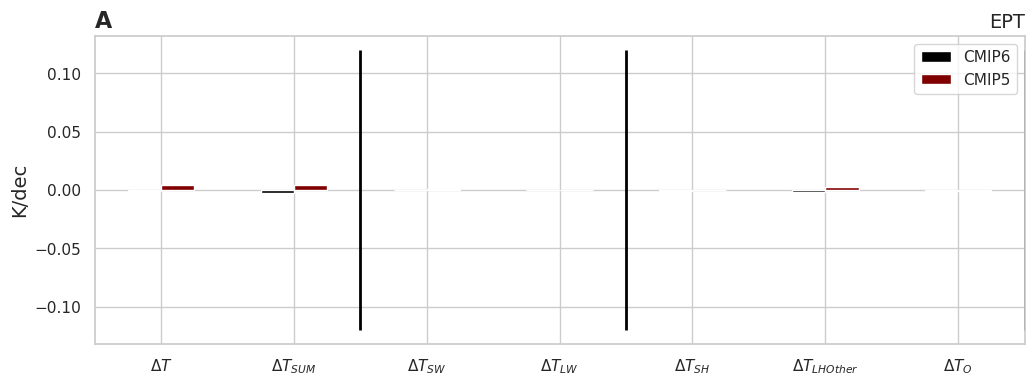

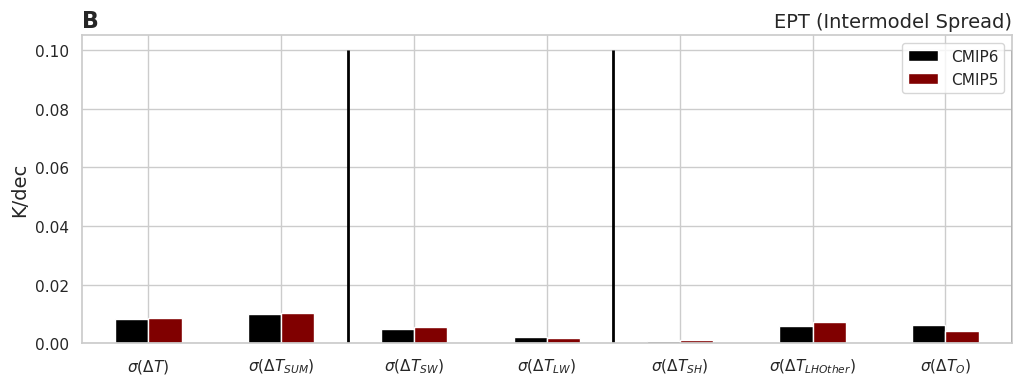

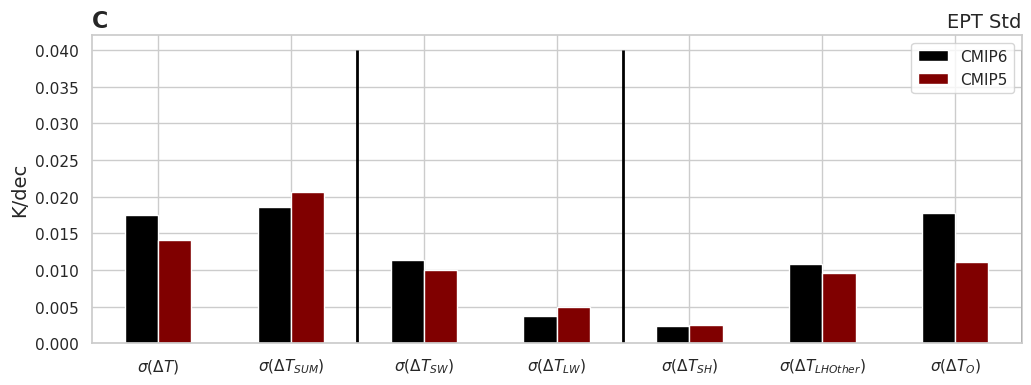

In [32]:
import seaborn as sns
import pandas as pd

region_name = "EPT"
# var_names = ["TOS", "NET", "SW", "LW", "LWC", "SWC", "CLOUD", "SH", "LH_Other", "O"]
# ticklabelsMean = [r"$\Delta T$", r"$\Delta T_{SUM}$", r"$\Delta T_{SW}$", r"$\Delta T_{LW}$", r"$\Delta T_{LWC}$", r"$\Delta T_{SWC}$", r"$\Delta T_{CLOUD}$",  r"$\Delta T_{SH}$", r"$\Delta T_{LH Other}$", r"$\Delta T_{O}$"]
# ticklabelsVar = [r"$\sigma (\Delta T)$", r"$\sigma (\Delta T_{SUM})$", r"$\sigma (\Delta T_{SW})$", r"$\sigma (\Delta T_{LW})$", r"$\sigma (\Delta T_{LWC})$", r"$\sigma (\Delta T_{SWC})$", r"$\sigma (\Delta T_{CLOUD})$",  r"$\sigma (\Delta T_{SH})$", r"$\sigma (\Delta T_{LH Other})$", r"$\sigma (\Delta T_{O})$"]
# labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]

var_names = ["TOS", "NET", "SW", "LW", "SH", "LH_Other", "O"]
ticklabelsMean = [r"$\Delta T$", r"$\Delta T_{SUM}$", r"$\Delta T_{SW}$", r"$\Delta T_{LW}$", r"$\Delta T_{SH}$", r"$\Delta T_{LH Other}$", r"$\Delta T_{O}$"]
ticklabelsVar = [r"$\sigma (\Delta T)$", r"$\sigma (\Delta T_{SUM})$", r"$\sigma (\Delta T_{SW})$", r"$\sigma (\Delta T_{LW})$", r"$\sigma (\Delta T_{SH})$", r"$\sigma (\Delta T_{LH Other})$", r"$\sigma (\Delta T_{O})$"]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
 
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
colors = ['black','maroon','#7570b3']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

# Plot 1: Sigma Means
m6 = means_cmip6.mean("model").to_pandas()
m5 = means_cmip5.mean("model").to_pandas()
pd.DataFrame({'CMIP6': m6.values,'CMIP5': m5.values}).plot.bar()
plt.xticks(rotation=0)
plt.ylabel("K/dec", fontsize=14)
plt.xticks(ticks=np.arange(len(var_names)), labels=ticklabelsMean)
plt.title("A", loc="left", fontweight="bold", fontsize=16)
plt.title(region_name, loc="right", fontsize=14)
plt.vlines(x=[1.5, 3.5, 6.5], ymin=-0.12, ymax=0.12, color="black", linewidth=2)

# Plot 2: Intermodel spread of Average Tendency Sigma Vars
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
colors = ['black','maroon','#7570b3']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

m6 = means_cmip6.std("model").to_pandas()
m5 = means_cmip5.std("model").to_pandas()
pd.DataFrame({'CMIP6': m6.values,'CMIP5': m5.values}).plot.bar()
plt.xticks(rotation=0)
plt.ylabel("K/dec", fontsize=14)
plt.xticks(ticks=np.arange(len(var_names)), labels=ticklabelsVar)
plt.title("B", loc="left", fontweight="bold", fontsize=16)
plt.vlines(x=[1.5, 3.5, 6.5], ymin=0, ymax=0.10, color="black", linewidth=2)
plt.title(f"{region_name} (Intermodel Spread)", loc="right", fontsize=14)

# Plot 3: Variance in Tendeancy for each model. Average average across enesemble 
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
colors = ['black','maroon','#7570b3']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

m6 = var_cmip6.std("model").to_pandas()
m5 = var_cmip5.std("model").to_pandas()
pd.DataFrame({'CMIP6': m6.values,'CMIP5': m5.values}).plot.bar()
plt.xticks(rotation=0)
plt.ylabel("K/dec", fontsize=14)
plt.xticks(ticks=np.arange(len(var_names)), labels=ticklabelsVar)
plt.title("C", loc="left", fontweight="bold", fontsize=16)
plt.vlines(x=[1.5, 3.5, 6.5], ymin=0, ymax=0.04, color="black", linewidth=2)
plt.title(f"{region_name} Std", loc="right", fontsize=14)

# Spatial Plots of SEB for 1 sig

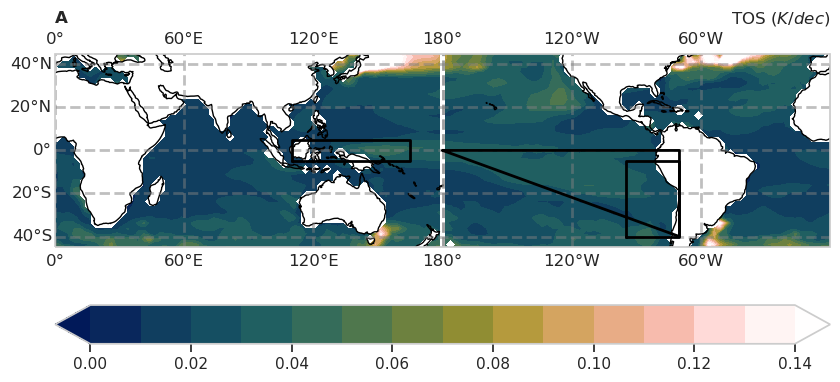

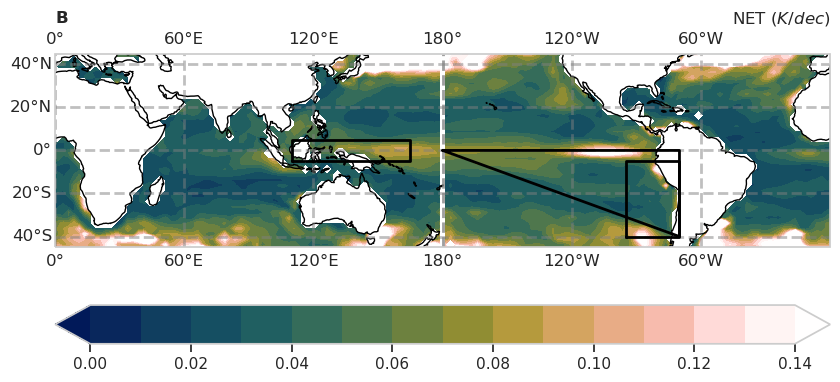

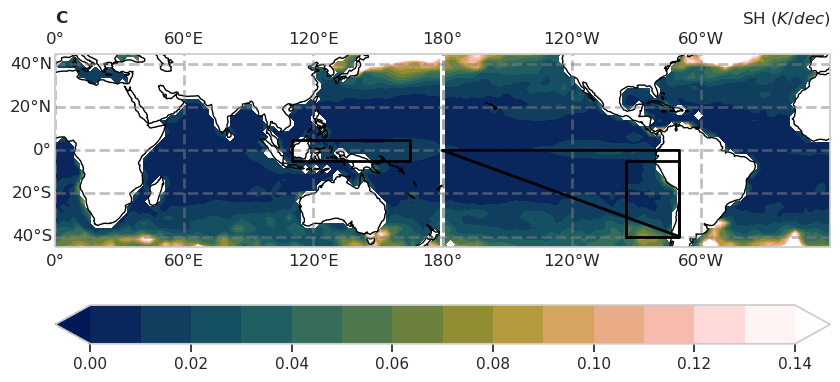

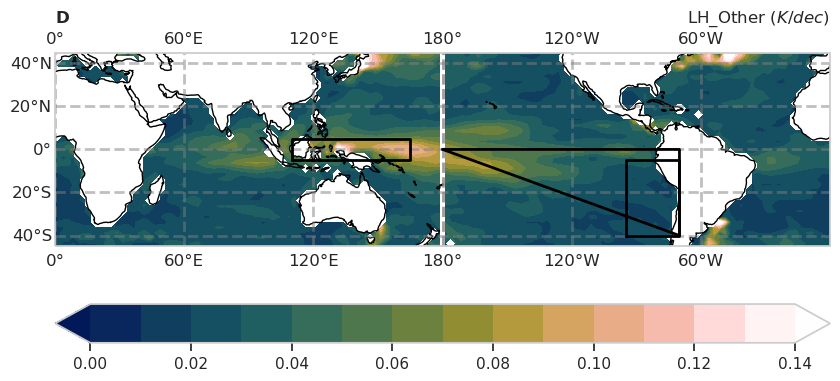

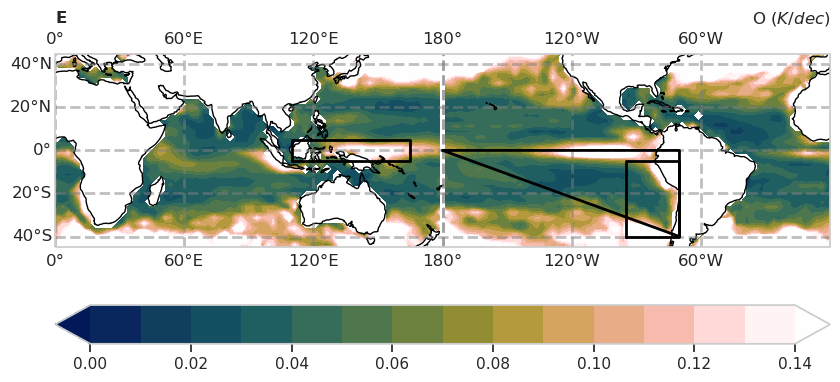

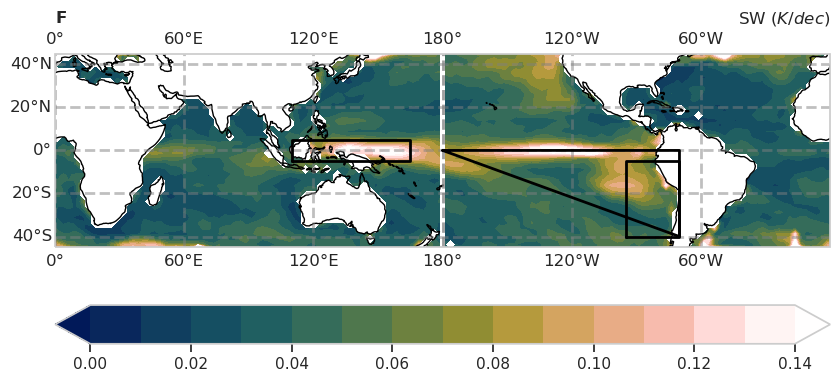

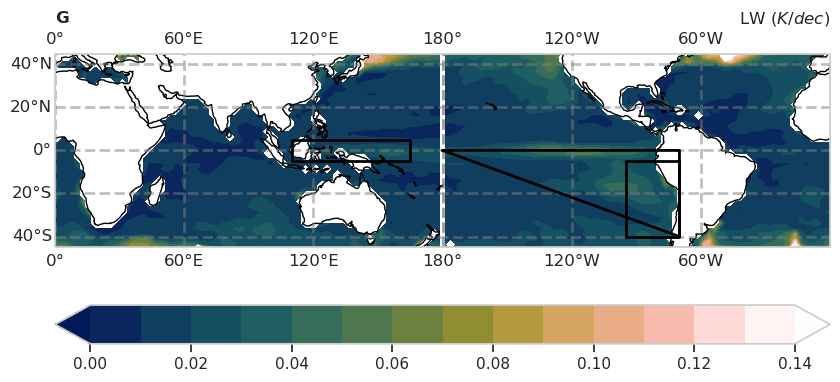

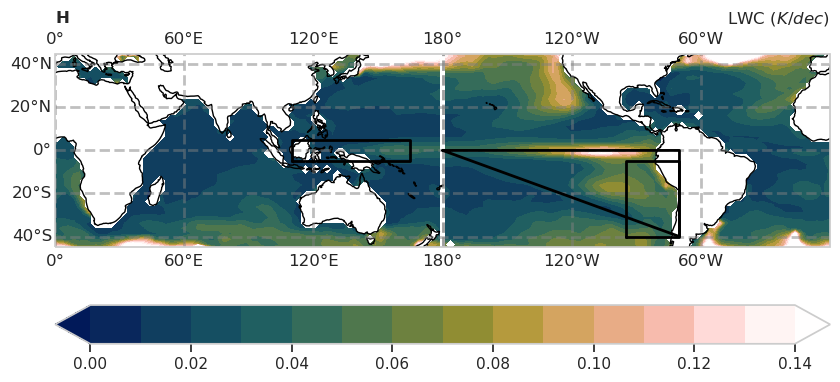

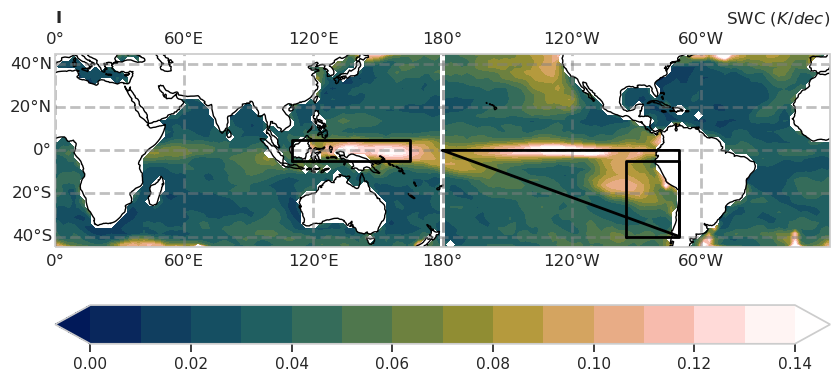

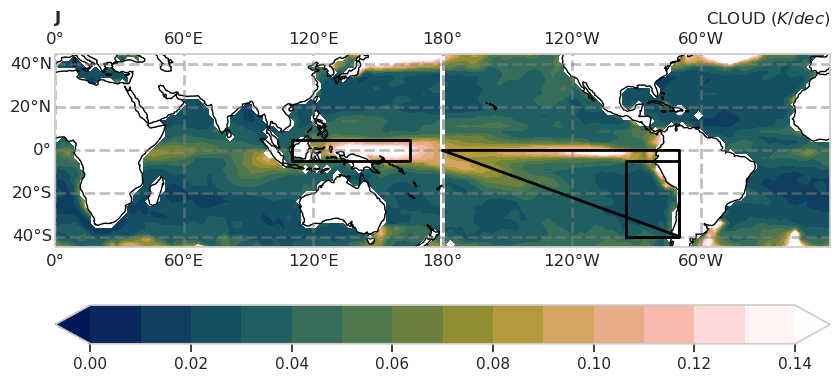

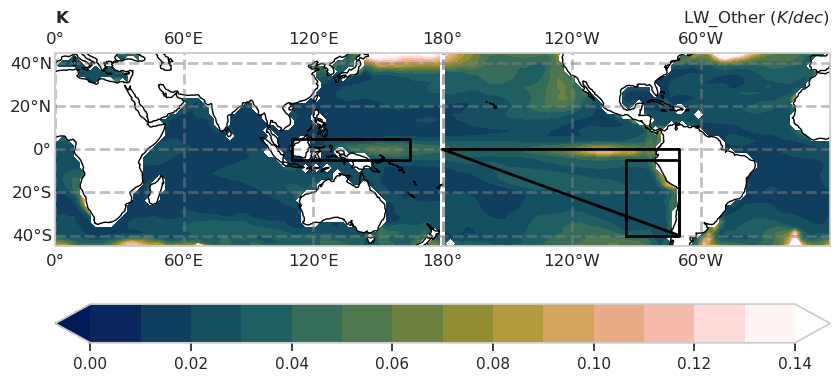

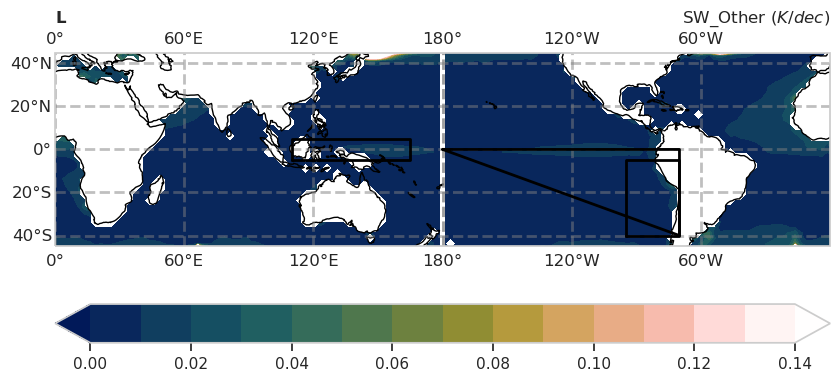

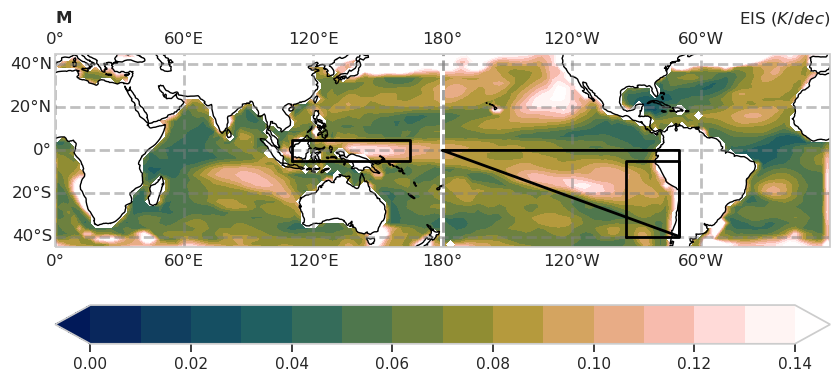

In [72]:
def plot_sigma_anoms(var_names, SST_T, SEB, region="EPSA"):

        for i, name in enumerate(var_names):
            _, flux_sig, _, _ = composite_sigma_anoms(X=SST_T, Y=SEB, var_name=name, region=region, remove_land=True)

            # Plot Individual SEB 
            global_plot(
                data=flux_sig.std("model"),
                lat=flux_sig.lat,
                lon=flux_sig.lon,
                pvalues=None, 
                # levels=np.arange(-.26, .28, .02),
                levels=np.arange(0, .15, .01),
                # cmap=cmc.roma_r, 
                cmap=cmc.batlowW, 
                left_title=labels[i], 
                right_title=f"{name} $(K/dec)$"
            )
            plt.savefig(f"figures/seb/mean_{name}_{region}.png")
            plt.show()

var_names = ["TOS", "NET", "SH", "LH_Other", "O", "SW", "LW", "LWC", "SWC", "CLOUD", "LW_Other", "SW_Other", "EIS"]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M"]

plot_sigma_anoms(var_names, SST_T_EPT_CMIP6, SEB=SEB_CMIP6, region="EPT")


# SEB Variance Analysis

In [33]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def get_region(name, flux, flux_region): 
    flux = remove_land_full(ds=flux[name], var=name)
    flux = fix_coords(flux.rename(name).to_dataset())

    if flux_region == "WE":
        flux_west = flux.sel(lat=slice(-5, 5), lon=slice(110, 165)).spatial.average(name)[name]
        flux_east = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
        flux = flux_west - flux_east
    elif flux_region == "EPSA":
        flux = flux.sel(lat=slice(-40, -5), lon=slice(-95, -70)).spatial.average(name)[name]
        # flux = flux.sel(lat=slice(-30, -0), lon=slice(-95, -70)).spatial.average(name)[name]
    elif flux_region == "SO":
        flux = flux.sel(lat=slice(-70, -50), lon=slice(-180, -75)).spatial.average(name)[name]
    elif flux_region == "E":
        flux = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
    elif flux_region == "EPT":
        flux = get_triangle(flux[name])
        flux = fix_coords(flux.rename(name).to_dataset()).spatial.average(name)[name]

    else: 
        raise ValueError("Invalid flux region")

    flux = flux.std("time")
    return flux

# get_region(name="TOS", flux=SEB_CMIP6, flux_region="EPSA")

In [34]:
import seaborn as sns

def scatter_plot_seb(
    var_names, 
    seb_cmip6,
    seb_cmip5, 
    sst_t_cmip6, 
    sst_t_cmip5, 
    SST_region="WE", 
    flux_region="WE", 
    scatter=True
):
    # sns.set(rc={'figure.figsize':(8,6)})

    tos6 = get_region("NET", seb_cmip6, flux_region)
    tos5 = get_region("NET", seb_cmip5, flux_region)

    fluxes6, fluxes5 = {}, {}
    for i, name in enumerate(var_names):
        flux6 = get_region(name, seb_cmip6, flux_region)
        flux5 = get_region(name, seb_cmip5, flux_region)

        fluxes6[name] = flux6.values
        fluxes5[name] = flux5.values

        # Plot Individual SEB 
        if scatter:
            create_scatter_hists(
                x6=flux6.values, 
                y6=tos6.values, #(sst_t_cmip6).std("time"), 
                x5=flux5.values, 
                y5=tos5.values, #(sst_t_cmip5).std("time"), 
                vline=[],
                xlabel=f"$\sigma$({name} Trend) {flux_region}", 
                ylabel=f"$\sigma$(SST Trend) {SST_region}",
            )

            plt.savefig(f"figures/seb/{name}_scatter_flux{flux_region}_sst{SST_region}_test.png")
            plt.show()

    return fluxes6, fluxes5

var_names = ["TOS", "NET", "O", "SW", "SWC", "LW", "LWC", "SH", "LH_Other", "CLOUD", "LW_Other", "SW_Other"] 
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N"]

EPT_flux6, EPT_flux5 = scatter_plot_seb(var_names, SEB_CMIP6, SEB_CMIP5, SST_T_EPT_CMIP6/3, SST_T_EPT_CMIP5/3, SST_region="EPT", flux_region="EPT", scatter=False)
EPSA_flux6, EPSA_flux5 = scatter_plot_seb(var_names, SEB_CMIP6, SEB_CMIP5, SST_T_EPSA_CMIP6/3, SST_T_EPSA_CMIP5/3, SST_region="EPSA", flux_region="EPSA", scatter=False)

/tmp/ipykernel_203286/1445873243.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fbs = cmip6.T.append(cmip5.T, ignore_index=True)
/tmp/ipykernel_203286/1445873243.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ens = labels6.T.append(labels5.T, ignore_index=True)


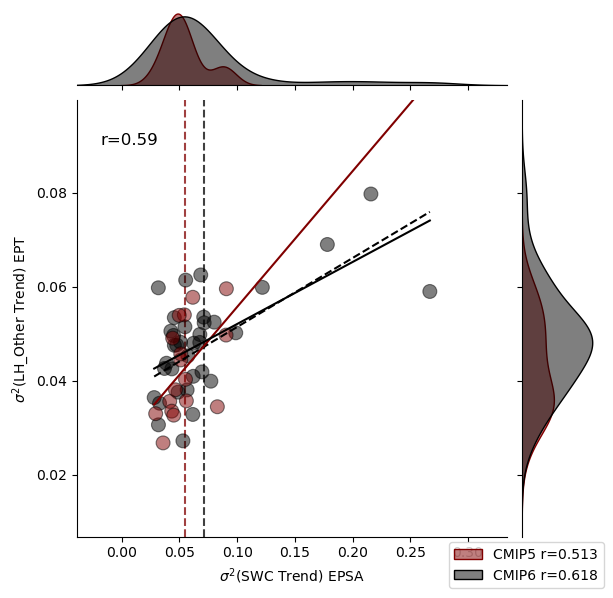

In [17]:
create_scatter_hists(
    x6=EPSA_flux6["SWC"],
    y6=EPT_flux6["LH_Other"],
    x5=EPSA_flux5["SWC"],
    y5=EPT_flux5["LH_Other"],
    vline=[],
    xlabel=f"$\sigma^2$(SWC Trend) EPSA",
    ylabel=f"$\sigma^2$(LH_Other Trend) EPT"
)

In [35]:
cov = np.zeros((len(EPT_flux6.keys()), len(EPSA_flux6.keys())))
for i, key_EPT in enumerate(EPT_flux6.keys()):
    for j, key_EPSA in enumerate(EPSA_flux6.keys()):
        reg = linregress(EPT_flux6[key_EPT], EPSA_flux6[key_EPSA])
        cov[i,j] = reg.rvalue

In [36]:
# https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas
import pandas as pd
df = pd.DataFrame(cov, index=EPT_flux6.keys(), columns=EPSA_flux6.keys())
df.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# df

/tmp/ipykernel_260199/3413920841.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,TOS,NET,O,SW,SWC,LW,LWC,SH,LH_Other,CLOUD,LW_Other,SW_Other
TOS,0.80,0.58,0.14,0.71,0.74,0.73,0.83,-0.05,0.06,0.06,0.78,0.53
NET,0.63,0.66,0.24,0.60,0.62,0.58,0.64,-0.06,0.17,-0.05,0.50,0.33
O,-0.01,0.39,0.51,0.19,0.13,0.11,-0.04,-0.18,-0.02,0.01,-0.07,0.15
SW,0.18,0.44,0.49,0.55,0.49,0.47,0.27,-0.28,-0.22,-0.03,0.14,0.09
SWC,0.32,0.48,0.44,0.68,0.64,0.63,0.46,-0.17,-0.18,-0.09,0.28,0.13
LW,0.35,0.43,0.30,0.42,0.41,0.47,0.43,-0.24,-0.05,0.17,0.35,0.22
LWC,0.76,0.55,0.18,0.71,0.73,0.74,0.81,0.05,0.04,0.11,0.77,0.54
SH,-0.17,-0.23,0.01,-0.25,-0.29,-0.25,-0.24,0.35,-0.17,0.46,0.04,0.31
LH_Other,0.63,0.59,0.14,0.59,0.62,0.61,0.68,0.06,0.38,0.03,0.48,0.32
CLOUD,0.55,0.56,0.27,0.45,0.45,0.42,0.50,-0.19,0.04,0.19,0.53,0.47


In [37]:
corr = pd.DataFrame(EPSA_flux6.values(), index=EPSA_flux6.keys()).T.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2).highlight_null(color='#f1f1f1')

/tmp/ipykernel_260199/25386217.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2).highlight_null(color='#f1f1f1')


,TOS,NET,O,SW,SWC,LW,LWC,SH,LH_Other,CLOUD,LW_Other,SW_Other
TOS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
NET,0.74,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
O,0.13,0.43,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SW,0.67,0.72,0.35,nan,nan,nan,nan,nan,nan,nan,nan,nan
SWC,0.72,0.74,0.28,0.99,nan,nan,nan,nan,nan,nan,nan,nan
LW,0.70,0.73,0.23,0.94,0.95,nan,nan,nan,nan,nan,nan,nan
LWC,0.94,0.75,0.12,0.78,0.83,0.85,nan,nan,nan,nan,nan,nan
SH,0.07,-0.04,0.08,-0.13,-0.12,-0.01,0.09,nan,nan,nan,nan,nan
LH_Other,0.26,0.32,0.11,0.01,0.03,0.11,0.23,0.41,nan,nan,nan,nan
CLOUD,0.15,-0.07,0.03,-0.26,-0.28,-0.14,0.03,0.32,0.27,nan,nan,nan


In [40]:
corr = pd.DataFrame(EPT_flux6.values(), index=EPT_flux6.keys()).T.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2).highlight_null(color='#f1f1f1')

/tmp/ipykernel_260199/4193306338.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2).highlight_null(color='#f1f1f1')


,TOS,NET,O,SW,SWC,LW,LWC,SH,LH_Other,CLOUD,LW_Other,SW_Other
TOS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
NET,0.75,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
O,0.03,0.40,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SW,0.22,0.18,0.44,nan,nan,nan,nan,nan,nan,nan,nan,nan
SWC,0.42,0.24,0.23,0.91,nan,nan,nan,nan,nan,nan,nan,nan
LW,0.36,0.29,0.12,0.66,0.64,nan,nan,nan,nan,nan,nan,nan
LWC,0.97,0.73,0.07,0.23,0.45,0.33,nan,nan,nan,nan,nan,nan
SH,-0.10,-0.12,0.29,-0.00,-0.01,-0.10,0.04,nan,nan,nan,nan,nan
LH_Other,0.66,0.81,0.19,0.25,0.33,0.41,0.63,-0.19,nan,nan,nan,nan
CLOUD,0.61,0.71,0.60,0.39,0.28,0.36,0.62,0.08,0.53,nan,nan,nan


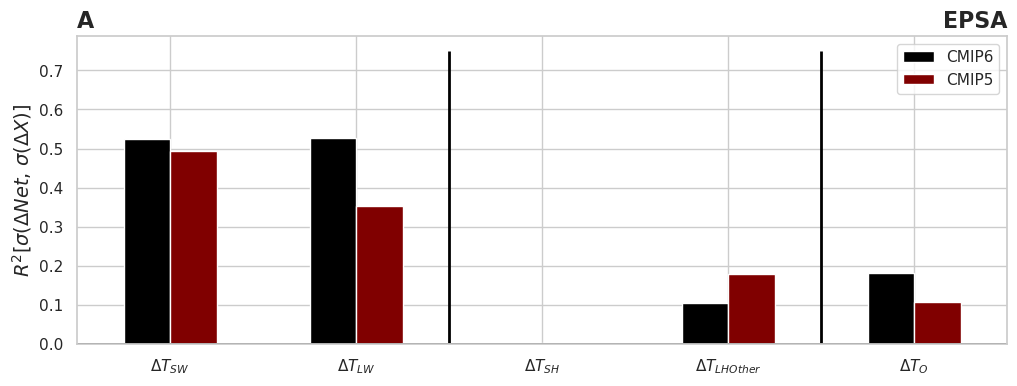

In [69]:
idx = ["SW", "LW", "SH", "LH_Other", "O"]
ticklabels = [r"$\Delta T_{SW}$", r"$\Delta T_{LW}$", r"$\Delta T_{SH}$", r"$\Delta T_{LH Other}$", r"$\Delta T_{O}$"]

corr6 = pd.DataFrame(EPSA_flux6.values(), index=EPSA_flux6.keys()).T.corr()
mask = np.zeros_like(corr6, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr6[mask] = np.nan

corr5 = pd.DataFrame(EPSA_flux5.values(), index=EPSA_flux5.keys()).T.corr()
mask = np.zeros_like(corr5, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr5[mask] = np.nan

sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
colors = ['black','maroon','#7570b3']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

pd.DataFrame({'CMIP6': corr6["NET"].loc[idx].values**2,'CMIP5': corr5["NET"].loc[idx].values**2}).plot.bar()
plt.xticks(rotation=0)
plt.ylabel(r"$R^2$[$\sigma(\Delta Net})$, $\sigma{(\Delta X)}$]", fontsize=14)
plt.xticks(ticks=np.arange(len(idx)), labels=ticklabels)
plt.title("A", loc="left", fontweight="bold", fontsize=16)
plt.title("EPSA", loc="right", fontweight="bold", fontsize=16)
plt.vlines(x=[1.5, 3.5, 6.5], ymin=0, ymax=.75, color="black", linewidth=2)
plt.hlines(y=[0], xmin=-1.0, xmax=4.5, color="black", linewidth=2)
# plt.title(f"{region_name} Std", loc="right", fontsize=14)

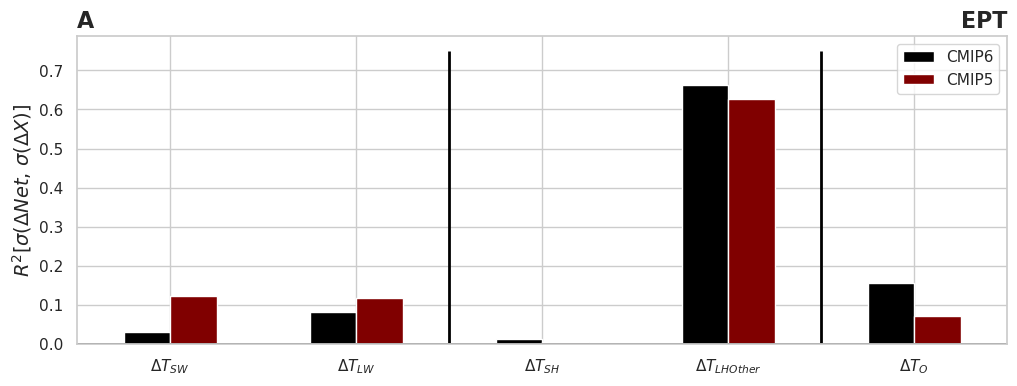

In [70]:
idx = ["SW", "LW", "SH", "LH_Other", "O"]
ticklabels = [r"$\Delta T_{SW}$", r"$\Delta T_{LW}$", r"$\Delta T_{SH}$", r"$\Delta T_{LH Other}$", r"$\Delta T_{O}$"]

corr6 = pd.DataFrame(EPT_flux6.values(), index=EPT_flux6.keys()).T.corr()
mask = np.zeros_like(corr6, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr6[mask] = np.nan

corr5 = pd.DataFrame(EPT_flux5.values(), index=EPT_flux5.keys()).T.corr()
mask = np.zeros_like(corr5, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr5[mask] = np.nan

sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
colors = ['black','maroon','#7570b3']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

pd.DataFrame({'CMIP6': corr6["NET"].loc[idx].values**2,'CMIP5': corr5["NET"].loc[idx].values**2}).plot.bar()
plt.xticks(rotation=0)
plt.ylabel(r"$R^2$[$\sigma(\Delta Net})$, $\sigma{(\Delta X)}$]", fontsize=14)
plt.xticks(ticks=np.arange(len(idx)), labels=ticklabels)
plt.title("A", loc="left", fontweight="bold", fontsize=16)
plt.title("EPT", loc="right", fontweight="bold", fontsize=16)
plt.vlines(x=[1.5, 3.5, 6.5], ymin=0, ymax=.75, color="black", linewidth=2)
plt.hlines(y=[0], xmin=-1.0, xmax=4.5, color="black", linewidth=2)
# plt.title(f"{region_name} Std", loc="right", fontsize=14)

# Violin Plots

In [56]:
import seaborn as sns

def violin_plot_tos(tos, right_title="", left_title=""):
    fig = plt.figure()
    sns.set_palette("husl")
    sns.violinplot(data=tos, inner="box", width=2)
    plt.grid()
    plt.xticks(fontsize=15)
    plt.vlines(x=[1.5, 3.5, 6.5], ymin=-0.12, ymax=0.32, color="black", linewidth=2)
    # Rotate the y-axis labels
    plt.tick_params(axis='x')
    fig.set_size_inches(15, 5)
    plt.xlabel("")
    plt.title(right_title, fontsize=15, loc="right", weight="bold")
    plt.title(left_title, fontsize=15, loc="left", weight="bold")

In [34]:
var_names = ["TOS", "NET", "SW", "LW", "LWC", "SWC", "CLOUD", "SH", "LH_Other", "O"]
fluxes = []
for cvar in var_names: 
    cflux = get_regional_means(fix_coords(SEB_CMIP6), cvar)["EPSA"]
    fluxes.append(cflux)

ds = xr.merge(fluxes)
ds

<xarray.Dataset>
Dimensions:   (model: 36, time: 120)
Coordinates:
  * model     (model) object 'EC-Earth3' 'GISS-E2-1-G' ... 'FIO-ESM-2-0'
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119
Data variables:
    TOS       (model, time) float64 0.009194 0.01637 ... -0.04648 -0.05251
    NET       (model, time) float64 0.0296 0.02541 0.02253 ... -0.1027 -0.1263
    SW        (model, time) float64 -0.0375 -0.02969 ... -0.0531 -0.03749
    LW        (model, time) float64 0.02019 0.009255 0.01282 ... 0.03574 0.02383
    LWC       (model, time) float64 0.01454 -0.007596 -0.02674 ... 0.1713 0.1905
    SWC       (model, time) float64 -0.04272 -0.03114 ... -0.07278 -0.06133
    CLOUD     (model, time) float64 -0.02817 -0.03874 ... 0.09847 0.1291
    SH        (model, time) float64 0.001025 0.0004469 ... 0.01421 0.007327
    LH_Other  (model, time) float64 -0.06326 -0.03571 ... -0.1133 -0.1046
    O         (model, time) float64 0.1112 0.08201 ... 0.04212 -0.0007522

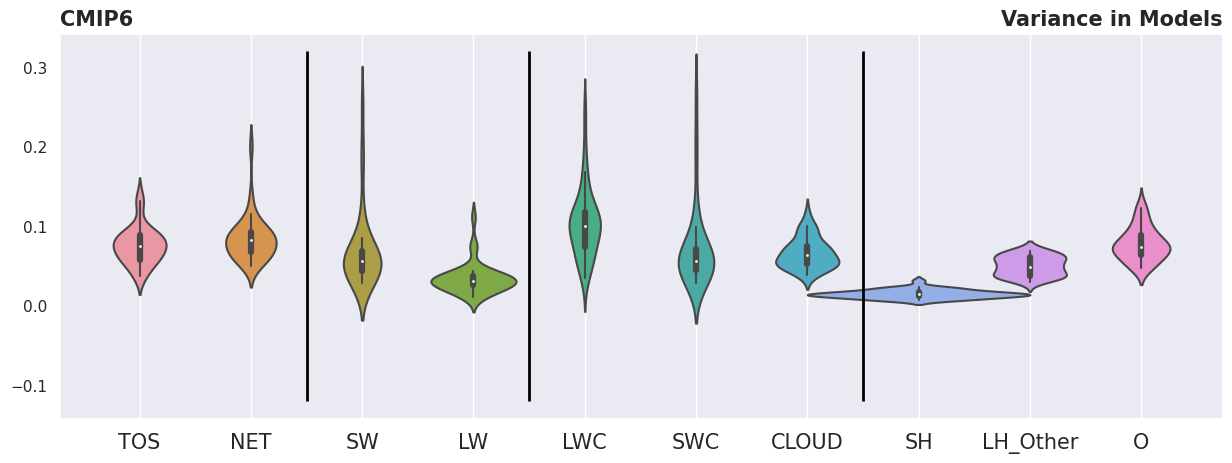

In [57]:
import pandas as pd

violin_plot_tos(ds.std("time").to_pandas(), left_title="CMIP6", right_title="Variance in Models")

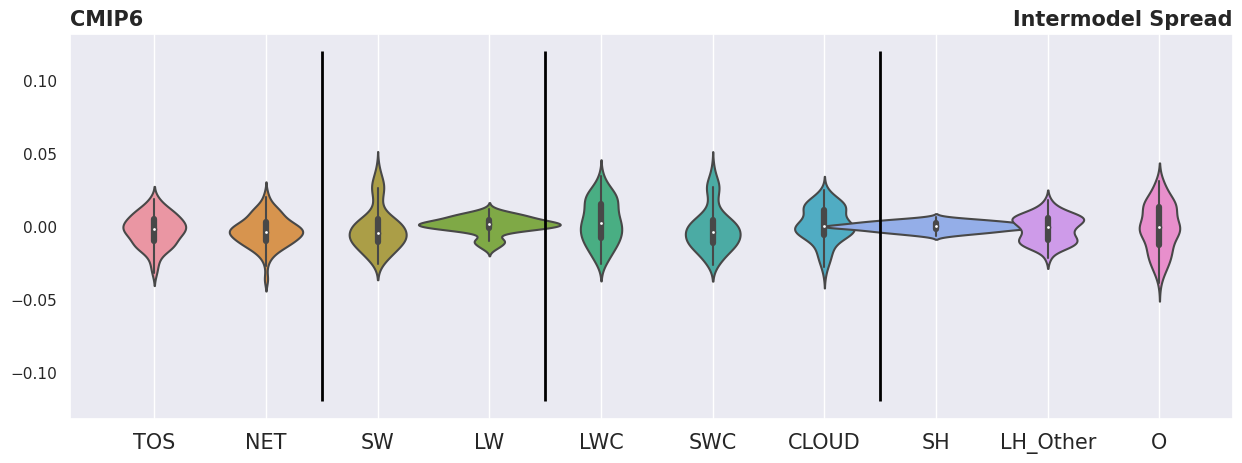

In [53]:
violin_plot_tos(ds.mean("model").to_pandas(), left_title="CMIP6", right_title="Intermodel Spread")

# EIS

In [108]:
eis_trends = get_regional_means(fix_coords(SEB_CMIP6["EIS"].to_dataset()), name="EIS")["EPSA"]
swc_trends = get_regional_means(fix_coords(SEB_CMIP6["SWC"].to_dataset()), name="SWC")["EPSA"]
lwc_trends = get_regional_means(fix_coords(SEB_CMIP6["LWC"].to_dataset()), name="LWC")["EPSA"]

# swc_trends = get_regional_means(fix_coords(SEB_CMIP6["SWC"].to_dataset()), name="SWC")["EPSA"]
# lwc_trends = get_regional_means(fix_coords(SEB_CMIP6["LWC"].to_dataset()), name="LWC")["EPSA"]

/tmp/ipykernel_262529/1666079509.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)


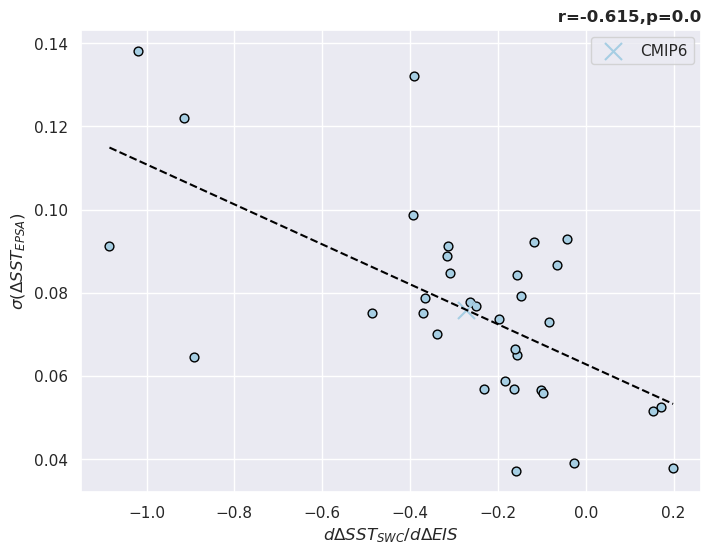

: 

In [113]:
eis_swc = xscore.linslope(eis_trends, swc_trends, dim="time")
eis_lwc = xscore.linslope(eis_trends, lwc_trends, dim="time")

eis_lwc = eis_lwc.where(eis_lwc > 0, np.nan, drop=True)
sst_cmip6 = (SST_T_EPSA_CMIP6/3).std("time").sel(model=eis_lwc.model)
eis_swc = eis_swc.sel(model=eis_lwc.model)


sns.set(rc={'figure.figsize':(8,6)})
plt.grid()
create_scatter(
    x6=eis_swc,
    y6=sst_cmip6,
    vline=[],
    xlabel=r"$d \Delta SST_{SWC} / d \Delta EIS$",
    ylabel=r"$\sigma (\Delta SST_{EPSA}$)",
)